<a href="https://colab.research.google.com/github/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data/blob/main/Finetune_BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install imbalanced-learn



In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [16]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load DataFrame
df = pd.read_csv("./updated_data9thFeb.csv")
df = df[['review_content', 'Sentiment']]

# Define a mapping function
sentiment_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Assuming df is your DataFrame
max_length = 1400
df = df[df['review_content'].apply(lambda x: len(x) <= max_length)]

print(f'Original dataset shape: {Counter(df["Sentiment"])}')





Original dataset shape: Counter({2: 454, 0: 71, 1: 40})


In [17]:

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_content'], df['Sentiment'],
                                                                    random_state=2021,
                                                                    test_size=0.3,
                                                                    stratify=df['Sentiment'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [18]:


# Import BERT-base pretrained model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

(array([76., 90., 73., 76., 79., 24., 54., 43., 21., 29.]),
 array([ 11. ,  34.5,  58. ,  81.5, 105. , 128.5, 152. , 175.5, 199. ,
        222.5, 246. ]),
 <BarContainer object of 10 artists>)

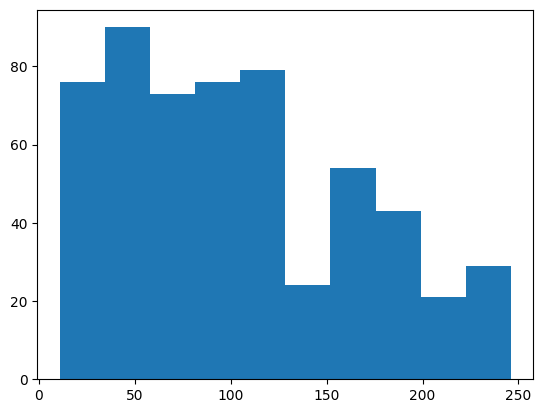

In [21]:
lens=[len(i.split()) for i in df.review_content]

import matplotlib.pyplot as plt
plt.hist(lens)


In [ ]:


# Tokenize and encode sequences
pad_len = 512
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length=pad_len, pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length=pad_len, pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length=pad_len, pad_to_max_length=True, truncation=True)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())

In [19]:
# Define batch size
batch_size = 64

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Freeze the BERT architecture
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
# Define the sentiment classification model
class SentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=3):
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize the model
model = SentimentClassifier(bert, num_classes=3)
model = model.to(device)

In [7]:

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function
cross_entropy = nn.NLLLoss(weight=weights)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:

# Number of training epochs
epochs = 1

# Training loop
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


In [20]:

# Evaluate the model
model.eval()
all_preds = []
with torch.no_grad():
    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        preds = model(sent_id, mask)
        all_preds.append(preds.detach().cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
pred_labels = np.argmax(all_preds, axis=1)

print(classification_report(val_y.numpy(), pred_labels, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        10
           1       1.00      0.00      0.00         6
           2       0.81      1.00      0.90        69

    accuracy                           0.81        85
   macro avg       0.94      0.33      0.30        85
weighted avg       0.85      0.81      0.73        85

